<div class="alert alert-block alert-info">

This jupyter notebook shows an example of how to read in and use the data from simulations described in the paper https://arxiv.org/abs/1905.00910: <br>

**STROOPWAFEL: Simulating rare outcomes from astrophysical populations, with application to gravitational-wave sources**

by Floor S. Broekgaarden, Stephen Justham, Selma E. de Mink, Jonathan Gair, Ilya Mandel, Simon Stevenson, Jim W. Barrett, Alejandro Vigna-Gómez and Coenraad J. Neijssel  <br>
<br>

The data can be found on Zenodo <br>
This script is written for python 3, but should also work for python 2 by changing in the last function in the histogram function the 'density=True'  to 'normed=True'
___

Last updated September 2019 <br>
For any queries, email: <br>


__fsbroekgaarden@gmail.com__

__fbroekgaarden@g.harvard.edu__

## Obtain data

- Download the file **STROOPWAFEL_data_BroekgaardenEtAll.tar.gz** from Zenodo and uncompress the data using: <br>
```
     tar xvzf STROOPWAFEL_data_BroekgaardenEtAll.tar.gz
```


The tar file contains the following 7 directories with data (DCO = Double Compact Object) :  <br>


**Traditional**        # data of the simulations run with sampling from the birth distributions (traditional sampling) at Z = 0.001 metallicity <br>
**ALL**      	       # data of ALL DCOs (simulation 1) at Z = 0.001 metallicity with STROOPWAFEL sampling<br>
**BHBH**     	       # data of BH-BH DCOs (simulation 2) at Z = 0.001 metallicity with STROOPWAFEL sampling<br>
**BHNS**     	       # data of BH-NS DCOs (simulation 3) at Z = 0.001 metallicity with STROOPWAFEL sampling<br>
**NSNS**     	       # data of NS-NS DCOs (simulation 4) at Z = 0.001 metallicity with STROOPWAFEL sampling<br>
**BHBH_50Msun**     	       # data of BH-BH DCOs that have total mass <= 50 Msun (simulation 5) at Z = 0.001 metallicity with STROOPWAFEL sampling<br>
**NSNS_50Myr**     # data of NS-NS DCOs that merge within <= 50 Myrs (simulation 6) at Z = 0.001 metallicity with STROOPWAFEL sampling<br>

which correspond with the 6 STROOPWAFEL sampled simulations + the reference "birth distribution Monte Carlo" sampled simulation ("Traditional"). These simulations are summarized in Table 2 of https://arxiv.org/pdf/1905.00910.pdf <br>

# Analyze STROOPWAFEL data

Using the functions **obtaindataSTROOPWAFEL** and **maskTargetDCOsSTROOPWAFEL** which are defined below we can obtain the needed parameters from the data and, for example, calculate the merger rate of all DCOs for both the traditional and STROOPWAFEL sampled simulations. 

- the function **obtaindataSTROOPWAFEL** obtains the wanted parameter that are described in README_DCOs.txt and README_systems.txt, such as the DCO masses or separation. 
- the function **maskTargetDCOsSTROOPWAFEL** returns a mask that can filter the wanted DCOtype. An example is BH-BH binaries that merge in a Hubble time. 


In the remaining notebook we will provide examples. For these examples we use the simulations from Traditional sampling (simulation 0) and ALL DCOs (simulation 1). But these can easily be changed to any of 'Traditional', 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' or 'BHBH_50Msun'  corresponding with the 6 simulations performed in our study. To do this, change the parameter ```simulation``` to the wanted simulation from the list 'Traditional', 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' or 'BHBH_50Msun' and changing, if needed, ```DCOtype``` to the corresponding target binary type from the list ['ALL', 'BHNS', 'BBH', 'NSNS' or 'NSNS_50Myr'] <br>

[1. Calculate speed up STROOPWAFEL sampling](1.-Calculate-speed-up-STROOPWAFEL-sampling) <br>
[2. Calculate merger rate in simulation](#2.-Calculate-merger-rate-in-simulation) <br>
[3. Plot fractional statistical sampling uncertainties](#3.-Plot-fractional-statistical-sampling-uncertainties)<br>
[4. Plot chirp mass distribution](#4.-Plot-chirp-mass-distribution)<br>
[5. Plot chirp mass kde distribution](#5.-Plot-chirp-mass-kde-distribution)<br>

#### import libraries and add path to data. 

In [1]:
import pandas as pd # can be downloaded here: https://pandas.pydata.org/
import numpy as np # can be installed through https://docs.scipy.org/doc/numpy/user/install.html

# path to directory with Traditional and STROOPWAFEL directories 'ALL', 'BHBH' etc.. 
pathData = '/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/STROOPWAFELmethod/PublicDATA/STROOPWAFEL_data_BroekgaardenEtAll'



In [2]:
def obtaindataSTROOPWAFEL(simulation='ALL', datafile='allDoubleCompactObjects.dat', path=pathData, paramHeader='separationInitial'):
    '''
    returns the wanted parameter and corresponding weights for a given simulation. In case of the STROOPWAFEL simulation
    the function combines the data from the exploration and refinement phase
    //
    parameters:
    simulation # simulation name. options are 'Traditional', 'ALL', 'BHNS', 'BHBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun'
    datafile # datafile that contains wanted parameter; either 'allDoubleCompactObjects.dat' or 'allSystems.dat'
    path # path to the directory with all the data
    paramHeader # header name of the wanted parameter in the allSystems.dat or allDoubleCompactObjects.dat files
    '''
    
    # read in datafiles. 
    # stroopwafel sampling has 2 directores: exploration and refinement phase
    if (simulation=='Traditional') :
        data = pd.read_csv(path + '/' + simulation + '/' + datafile, sep='\t', header=2)
        weights = np.ones(len(data['ID'])) # all traditional weights are 1

    else: # Stroopwafel sampling
        path_expl = path + '/' + simulation + '/exploration/'
        path_ref  = path + '/' + simulation + '/refinement/'

        # Set name of weights textfile
        if datafile=='allDoubleCompactObjects.dat':
            weightsfilename = 'allDoubleCompactObjectsWeights.txt'
        elif datafile=='allSystems.dat':
            weightsfilename = 'allSystemsWeights.txt'
        else:
            print('error: name of datafile not correct in obtaindataSTROOPWAFEL()')        
        
        # read in datafiles
        data_expl = pd.read_csv(path_expl  + datafile, sep='\t', header=2)
        data_weights_expl = pd.read_csv(path_expl  + weightsfilename, sep='\t', header=2)

        data_ref = pd.read_csv(path_ref  + datafile, sep='\t', header=2)
        data_weights_ref = pd.read_csv(path_ref + weightsfilename, sep='\t', header=2)

        # combine data and weights from exploration and refinement                     
        data = pd.concat([data_expl, data_ref])
        weights = pd.concat([data_weights_expl['weight'], data_weights_ref['weight']])
    
    param = data[paramHeader]
    
    return np.asarray(param), np.asarray(weights)


def maskTargetDCOsSTROOPWAFEL(DCOtype='ALL', simulation='ALL', boolDCOmask=[1,1,0], path=pathData):
    """
    returns mask of DCOs of interest
    //
    parameters:
    DCOtype # describes target binary. Options are: 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun
    simulation # name of simulation. Options are: Traditional, 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun'
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    path # pathname to Directory where _exploratory & _refinement directories are
    """
    
    Hubble, RLOF, Pessimistic = boolDCOmask
    
    # all needed parameters are in the DCO file
    datafile = 'allDoubleCompactObjects.dat'
 
    # data for DCO type mask
    stellarType1, _ =  obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='stellarType1')  
    stellarType2, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='stellarType2') 
    # data for boolDCOmask: 
    mergesInHubbleTimeFlag, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='mergesInHubbleTimeFlag')  
    RLOFSecondaryAfterCEE, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='RLOFSecondaryAfterCEE') 
    optimisticCEFlag, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='optimisticCEFlag') 
    
    if (DCOtype == 'NSNS_50Myr') : # obtain merger time
        tc, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='tc')   
    if (DCOtype == 'BHBH_50Msun') : # obtain BH masses 
        M1, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='M1')         
        M2, _ = obtaindataSTROOPWAFEL(simulation, datafile, path, paramHeader='M2')             
        Mtot = M1 + M2 
        
    # mask binaries of given simulation (i.e. DCO type)
    if (DCOtype == 'all') | (DCOtype == 'ALL') :
        mask0 = ((stellarType1== 14) | (stellarType1== 13))
    elif (DCOtype == 'BBH') | (DCOtype == 'BHBH')  :
        mask0 = ((stellarType1== 14) & (stellarType2== 14))
    elif (DCOtype == 'BNS') | (DCOtype == 'NSNS')  :
        mask0 = ((stellarType1 == 13) & (stellarType2 == 13))
    elif (DCOtype == 'BHNS') | (DCOtype == 'NSBH'):
        mask0 = ((stellarType1== 13) & (stellarType2== 14)) | \
            ((stellarType1== 14) & (stellarType2== 13) )           
    elif (DCOtype == 'NSNS_50Myr') :
        mask0 = ((stellarType1 == 13) & (stellarType2 == 13) & (tc <= 50)  )
    elif (DCOtype == 'BHBH_50Msun'):
        mask0 = ((stellarType1== 14) & (stellarType2== 14) & (Mtot >= 50))     
    else:
        print('error: DCO type not known')
    
    # boolDCOmasks:
    # Hubble mask
    if Hubble:
        mask1 = (mergesInHubbleTimeFlag==True) 
    elif not Hubble:
        mask1 = (mergesInHubbleTimeFlag==True) |  (mergesInHubbleTimeFlag==False) 
    # RLOF mask
    if RLOF:
        mask2 = (RLOFSecondaryAfterCEE==False)
    elif not RLOF:
        mask2 = (RLOFSecondaryAfterCEE==False) | (RLOFSecondaryAfterCEE==True)
    # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
    if Pessimistic:
        mask3 = np.logical_not(optimisticCEFlag==1)
    elif not Pessimistic:
        mask3 = np.logical_not(optimisticCEFlag==1) + \
        np.logical_not(optimisticCEFlag==0)   
    
    # combine the different masks 
    combinedmask = mask0 * mask1 * mask2 * mask3

    return combinedmask



## 1. Calculate speed up STROOPWAFEL sampling

We can now calculate the speed up from STROOPWAFEL sampling compared to Traditional sampling by using the functions above to obtain the number of binaries of the target simulation that we find in each simulation. 

In [3]:

#Traditional sampling (simulation 0)
sim = 'Traditional'
# obtain the separations and weights of all DCOs from Traditional simulation
separationInitial_0, _ = obtaindataSTROOPWAFEL(paramHeader='separationInitial', simulation=sim,\
                      datafile='allDoubleCompactObjects.dat', path=pathData)
# create mask with ALL DCOs that merge in a Hubble time (boolDCOmask=[1,1,0])
DCOmask_0 = maskTargetDCOsSTROOPWAFEL(DCOtype='ALL', simulation=sim, boolDCOmask=[1,1,0], path=pathData)

# the number of target binaries in this simulation is
NDCO_0 = len(separationInitial_0[DCOmask_0]) 
print()
print('The target binaries are: ', 'ALL DCOs that merge in a Hubble time')
print('The number of target binaries found in the', sim, 'simulation equals ', NDCO_0)
print()




The target binaries are:  ALL DCOs that merge in a Hubble time
The number of target binaries found in the Traditional simulation equals  6711



In [4]:
#STROOPWAFEL sampling focused on ALL DCOs (simulation 1)
sim = 'ALL'
# obtain the separations and weights of all DCOs from Traditional simulation
separationInitial_1, _ = obtaindataSTROOPWAFEL(paramHeader='separationInitial', simulation=sim,\
                      datafile='allDoubleCompactObjects.dat', path=pathData)
# create mask with ALL DCOs that merge in a Hubble time (boolDCOmask=[1,1,0])
DCOmask_1 = maskTargetDCOsSTROOPWAFEL(DCOtype='ALL', simulation=sim, boolDCOmask=[1,1,0], path=pathData)

# the number of target binaries in this simulation is
NDCO_1 = len(separationInitial_1[DCOmask_1]) 
print()
print('The target binaries are: ', sim,  ' DCOs that merge in a Hubble time')
print('The number of target binaries found in the', sim, 'STROOPWAFEL simulation equals ', NDCO_1)
print()




The target binaries are:  ALL  DCOs that merge in a Hubble time
The number of target binaries found in the ALL STROOPWAFEL simulation equals  234768



In [5]:
print('the gain = ', float(NDCO_1)/NDCO_0)

the gain =  34.98256593652213


So in the end  there are **6711** DCOs that merge in a Hubble time in the Traditional sampled simulation, and **234768** target binaries in the STROOPWAFEL sampled simulation. These are the numbers that are quoted in Table 1 of https://arxiv.org/pdf/1905.00910.pdf where  **$N_{T,traditional}$**  are the number of target binaries from the Traditional sampled simulation (here 6711 for ALL mergers) and **$N_{T,STROOPWAFEL}$** are the Number of binaries from the STROOPWAFEL simulation (here 234768). These numbers are also quoted in parentheses in Fig. 6 and Fig. 7 of https://arxiv.org/pdf/1905.00910.pdf. <br>

The overall gain in DCOs of the target population is given by: <br>

$ N_{T,STROOPWAFEL} / N_{T,traditional} =  234768 / 6711 \approx 35 $ <br>

which is the number corresponding to the results for the **'ALL DCO mergers'** simulation shown in the last column of Table 1 (first row) and top left panel of Fig. 4 of https://arxiv.org/pdf/1905.00910.pdf




**with the function below we can obtain all the overall gains quoted in the last column of Table 2 of https://arxiv.org/pdf/1905.00910.pdf**

In [6]:
def calculateGainSTROOPWAFEL(simulation='ALL', DCOtype='ALL', path=pathData):
    """function that calculates the gain in Table 2 of the STROOPWAFEL paper
    //
    parameters:
    DCOtype # describes target binary. Options are: 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun
    simulation # name of simulation. Options are: Traditional, 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun'
    path # pathname to Directory where _exploratory & _refinement directories are
    """
    
    ####Traditional sampling (simulation 0)
    # obtain the separations of all DCOs from Traditional simulation
    separationInitial_0, _ = obtaindataSTROOPWAFEL(paramHeader='separationInitial', simulation='Traditional',\
                          datafile='allDoubleCompactObjects.dat', path=path)
    # create mask with ALL DCOs that merge in a Hubble time (boolDCOmask=[1,1,0])
    DCOmask_0 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation='Traditional', boolDCOmask=[1,1,0], path=path)
    # the number of target binaries in the Traditional simulation is
    NDCO_0 = len(separationInitial_0[DCOmask_0]) 

    
    ## STROOPWAFEL sampling ###
    # obtain the separations and weights of all DCOs from Traditional simulation
    separationInitial_1, _ = obtaindataSTROOPWAFEL(paramHeader='separationInitial', simulation=simulation,\
                          datafile='allDoubleCompactObjects.dat', path=path)
    # create mask with ALL DCOs that merge in a Hubble time (boolDCOmask=[1,1,0])
    DCOmask_1 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation=simulation, boolDCOmask=[1,1,0], path=path)
    # the number of target binaries in the STROOPWAFEL simulation is
    NDCO_1 = len(separationInitial_1[DCOmask_1])     
    
    
    gain = int(round(float(NDCO_1) / NDCO_0))
    
    return gain 



In [7]:
## print the gains of STROOPWAFEL from Table 2:
print( 'gain of simulation 1 (ALL mergers) = ', calculateGainSTROOPWAFEL(simulation='ALL', DCOtype='ALL', path=pathData))
print( 'gain of simulation 2 (BHBH mergers) = ',  calculateGainSTROOPWAFEL(simulation='BHBH',DCOtype='BHBH', path=pathData))
print( 'gain of simulation 3 (BHNS mergers) = ',  calculateGainSTROOPWAFEL(simulation='BHNS',DCOtype='BHNS', path=pathData))
print( 'gain of simulation 4 (NSNS mergers) = ',  calculateGainSTROOPWAFEL(simulation='NSNS',DCOtype='NSNS', path=pathData))
print( 'gain of simulation 5 (BHBH with Mtot >=50 Msun mergers) = ',  calculateGainSTROOPWAFEL(simulation='BHBH_50Msun',DCOtype='BHBH_50Msun', path=pathData))
print( 'gain of simulation 6 (NSNS with tcoalescence <= 50 Myr mergers) = ',  calculateGainSTROOPWAFEL(simulation='NSNS_50Myr',DCOtype='NSNS_50Myr', path=pathData))



gain of simulation 1 (ALL mergers) =  35
gain of simulation 2 (BHBH mergers) =  53
gain of simulation 3 (BHNS mergers) =  39
gain of simulation 4 (NSNS mergers) =  45
gain of simulation 5 (BHBH with Mtot >=50 Msun mergers) =  203
gain of simulation 6 (NSNS with tcoalescence <= 50 Myr mergers) =  24


## 2. Calculate merger rate in simulation

It is also possible to calculate the fractional merger rate of the target population in the COMPAS simulation. This is done similar to the example above, but by incorporating the weights. The function
`calculateFormationRate()` below calculates the ractional merger rate for a given simulation and target population

In [8]:
def printDCOmaskString(boolDCOmask=[1,1,0]):
    """
    returns string that contains the boolDCOmask selection, 
    This is printed in the function calculateFormationRate()
    //
    parameters:
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    """
    Hubble, RLOF, Pessimistic = boolDCOmask
    
    # boolDCOmasks:
    # Hubble mask
    if Hubble:
        string1 = 'mergers in a Hubble time, ' 
    elif not Hubble:
        string1 = ''
    # RLOF mask
    if RLOF:
        string2 = ' that do not have Roche Lobe overflow immediately after the Common Envelope event,'
    elif not RLOF:
        string2 = ''
    # Pessimistic mask :  if True mask systems that have optimistic CE flag ==1
    if Pessimistic:
        string3 = ' which are optimistic.' 
    elif not Pessimistic:
        string3 = ' which are pessimistic.'
        
    return string1 + string2 + string3


def calculateFormationRate(simulation='ALL', DCOtype='ALL', boolDCOmask=[1,1,0], path=pathData):
    """
    returns fractional formation rate of the target binary (given by DCOtype and boolDCOmask)
    //
    parameters:
    simulation # name of simulation. Options are: Traditional, 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun'
    DCOtype # describes target binary. Options are: 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun
    boolDCOmask = [Hubble, RLOF, Pessimistic] # boolean values whether to mask mergers in a HUbble time, 
    binaries that have RLOFSecondaryAfterCEE = True, and Pessimistic binaries (i.e. optimisticCEFlag == 0)
    path # pathname to Directory where _exploratory & _refinement directories are
    """
    # obtain the separations and weights of all DCOs from Traditional simulation from allDoubleCompactObjects.dat
    _, weights = obtaindataSTROOPWAFEL(paramHeader='separationInitial', simulation=simulation,\
                                       datafile='allDoubleCompactObjects.dat', path=path)
    # create mask with ALL DCOs that merge in a Hubble time (boolDCOmask=[1,1,0])
    DCOmask = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation=simulation,\
                                        boolDCOmask=boolDCOmask, path=path)

    # obtain a parameter from the allSystems.dat to get the total Number of binaries simulated of Traditional simulation
    ID, _ = obtaindataSTROOPWAFEL(paramHeader='ID', simulation=simulation,\
                                  datafile='allSystems.dat', path=path)
    NbinariesSampled = len(ID)
    
    # the total weight of target binaries in this simulation is
    totalweights_DCO = np.sum(weights[DCOmask])
    
    # print the outcomes
    DCOmaskstring = printDCOmaskString(boolDCOmask=boolDCOmask)
    print('This is a calculation for the %s simulation'%sim)
    print('The target binaries are: ', DCOtype, DCOmaskstring)
    print('The total weight of the target binaries in the', simulation, 'simulation with ', \
          NbinariesSampled ,' binaries equals ', totalweights_DCO)
    print('the estimated fractional rate of the target population in our simulation equals ', totalweights_DCO/NbinariesSampled)
    
    return



#### Example: fractional merger rate of ALL mergers from the Traditional sampled simulation (simulation 0)

In [9]:
calculateFormationRate(simulation = 'Traditional', DCOtype='ALL', boolDCOmask=[1,1,0], path=pathData)



This is a calculation for the ALL simulation
The target binaries are:  ALL mergers in a Hubble time,  that do not have Roche Lobe overflow immediately after the Common Envelope event, which are pessimistic.
The total weight of the target binaries in the Traditional simulation with  1000000  binaries equals  6711.0
the estimated fractional rate of the target population in our simulation equals  0.006711


####  Example: fractional merger rate of ALL mergers from the STROOPWAFEL sampled simulation (simulation 1)

In [10]:
calculateFormationRate(simulation='ALL', DCOtype='ALL', boolDCOmask=[1,1,0], path=pathData)



This is a calculation for the ALL simulation
The target binaries are:  ALL mergers in a Hubble time,  that do not have Roche Lobe overflow immediately after the Common Envelope event, which are pessimistic.
The total weight of the target binaries in the ALL simulation with  1000001  binaries equals  6562.143916108497
the estimated fractional rate of the target population in our simulation equals  0.006562137353971143


The estimated fractional rates of the target population, $\mathcal{R_{\rm{T}}}, $  of the target population should be similar between the Traditional sampled simulation (simulation 0) and the STROOPWAFEL sampled simulation (here simulation 1). Small differences between the two estimates are caused by sampling (Poisson) noise. These estimated physical rates of the target population (i.e. $\approx 0.0066$ for ALL mergers in a Hubble time) are shown in Fig. 2 and Fig. 3 of https://arxiv.org/pdf/1905.00910.pdf with coloured vertical bars.  <br> 

## 3. Plot fractional statistical sampling uncertainties

Using the data from all the simulations, the function `plotUncertainties()` below recreates Figure 5 in  https://arxiv.org/pdf/1905.00910.pdf. <br>



In [11]:
import matplotlib.pyplot as plt
from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams

# below is just for the text
rc('font', family='serif', weight = 'bold')
rc('text', usetex=True)



In [12]:


def plotUncertainties(ax=None,  DCOtype='ALL', i=0, path=pathData): 
    """
    (1) plots the fractional statistical sampling uncertainties for the given target population
    for the Traditional and STROOPWAFEL sampled simulation. (2) prints the ratio between the two fractional
    uncertainties. 
    //
    parameters:
    DCOtype # describes target binary. Options are: 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun
    i # indicator for nr of simulation used to determine labels and colors
    path # pathname to Directory where _exploratory & _refinement directories are
    """
    
    # list of rounded factors of improvement in fractional uncertainty by STROOPWAFEL
    factorlist = [r'\textbf{4}',r'\textbf{6}',r'\textbf{4}',r'\textbf{4}',r'\textbf{10.5}',r'\textbf{3}']


    # Traditional sampled simulation
    # obtain total number of binaries sampled. this is  1E6
    ID, _ = obtaindataSTROOPWAFEL(paramHeader='ID', simulation='Traditional',\
                                  datafile='allSystems.dat', path=path)
    NbinariesSampled_0 = len(ID)
    # obtain the weights
    _, weights_0 = obtaindataSTROOPWAFEL(paramHeader='M2', simulation='Traditional',\
                          datafile='allDoubleCompactObjects.dat', path=path)  
    DCOmask_0 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation='Traditional', boolDCOmask=[1,1,0], path=path) 
    weights_0 = weights_0[DCOmask_0]
    
    # estimate rate of DCOtype (cf. Eq. 14 of https://arxiv.org/pdf/1905.00910.pdf)
    rate_0 = np.sum(weights_0)/NbinariesSampled_0
    
    
    # STROOPWAFEL sampled simulation
    # obtain total number of binaries sampled. this is ~ 1E6
    ID, _ = obtaindataSTROOPWAFEL(paramHeader='ID', simulation=DCOtype,\
                                  datafile='allSystems.dat', path=path)
    NbinariesSampled_1 = len(ID)
    # obtain the weights
    _, weights_1 = obtaindataSTROOPWAFEL(paramHeader='M2', simulation=DCOtype,\
                          datafile='allDoubleCompactObjects.dat', path=path)    
    DCOmask_1 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation=DCOtype, boolDCOmask=[1,1,0], path=path) 
    weights_1 =  weights_1[DCOmask_1]  
    
    # estimate rate of DCOtype (cf. Eq. 14 of https://arxiv.org/pdf/1905.00910.pdf)
    rate_1 = np.sum(weights_1)/NbinariesSampled_1
    
    # samples that are not masked by DCOmask have outcome '0' (phi(x_i) = 0)
    Nzeros_0 = int(NbinariesSampled_0 - len(weights_0))
    Nzeros_1 = int(NbinariesSampled_1 - len(weights_1))
    
    # get all phi_x outcomes and estimate fractional uncertainty for Traditional simulation
    phi_x_0 =  np.concatenate((np.zeros(Nzeros_0), weights_0))  # phi(x) in Eq. 14
    uncertainty_0 = np.std(phi_x_0, ddof = 1) / np.sqrt(NbinariesSampled_0)
    fractional_uncertainty_0 =  uncertainty_0 / rate_0  # Eq. 15
    
    # get all phi_x outcomes and estimate fractional uncertainty for STROOPWAFEL simulation
    phi_x_1 =  np.concatenate((np.zeros(Nzeros_1), weights_1)) # phi(x) in Eq. 14
    uncertainty_1 = np.std(phi_x_1, ddof = 1)  / np.sqrt(NbinariesSampled_1)
    fractional_uncertainty_1 = uncertainty_1 / rate_1  # Eq. 15
    

    ax.bar(i-0.14, fractional_uncertainty_1, lw = 2, color=colors[i], zorder = 100, width = 0.5, alpha  = 0.85, linewidth = 0, edgecolor = colors[i])
    ax.bar(i+0.14, fractional_uncertainty_0,  lw = 2, color='gray', zorder = 2, width = 0.5, alpha = 0.85, edgecolor = 'gray', linewidth = 0, hatch="/")
    ax.text(i+0.14, fractional_uncertainty_0 + 0.0012, factorlist[i] +r'$\mathbf{\times}$', fontsize=40,  weight='bold', horizontalalignment='center', verticalalignment='center', color = colors[i])
    ax.tick_params(labelsize=30)


    print('\n' + 'For the target population = ', DCOtype)
    print('STROOPWAFEL sampling results in ', round(fractional_uncertainty_0/fractional_uncertainty_1, 2)\
          , 'times smaller fractional sampling uncertainties')

    return



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.



For the target population =  ALL
STROOPWAFEL sampling results in  3.87 times smaller fractional sampling uncertainties

For the target population =  BHBH
STROOPWAFEL sampling results in  6.29 times smaller fractional sampling uncertainties

For the target population =  BHNS
STROOPWAFEL sampling results in  3.92 times smaller fractional sampling uncertainties

For the target population =  NSNS
STROOPWAFEL sampling results in  4.07 times smaller fractional sampling uncertainties

For the target population =  BHBH_50Msun
STROOPWAFEL sampling results in  10.44 times smaller fractional sampling uncertainties

For the target population =  NSNS_50Myr
STROOPWAFEL sampling results in  3.07 times smaller fractional sampling uncertainties


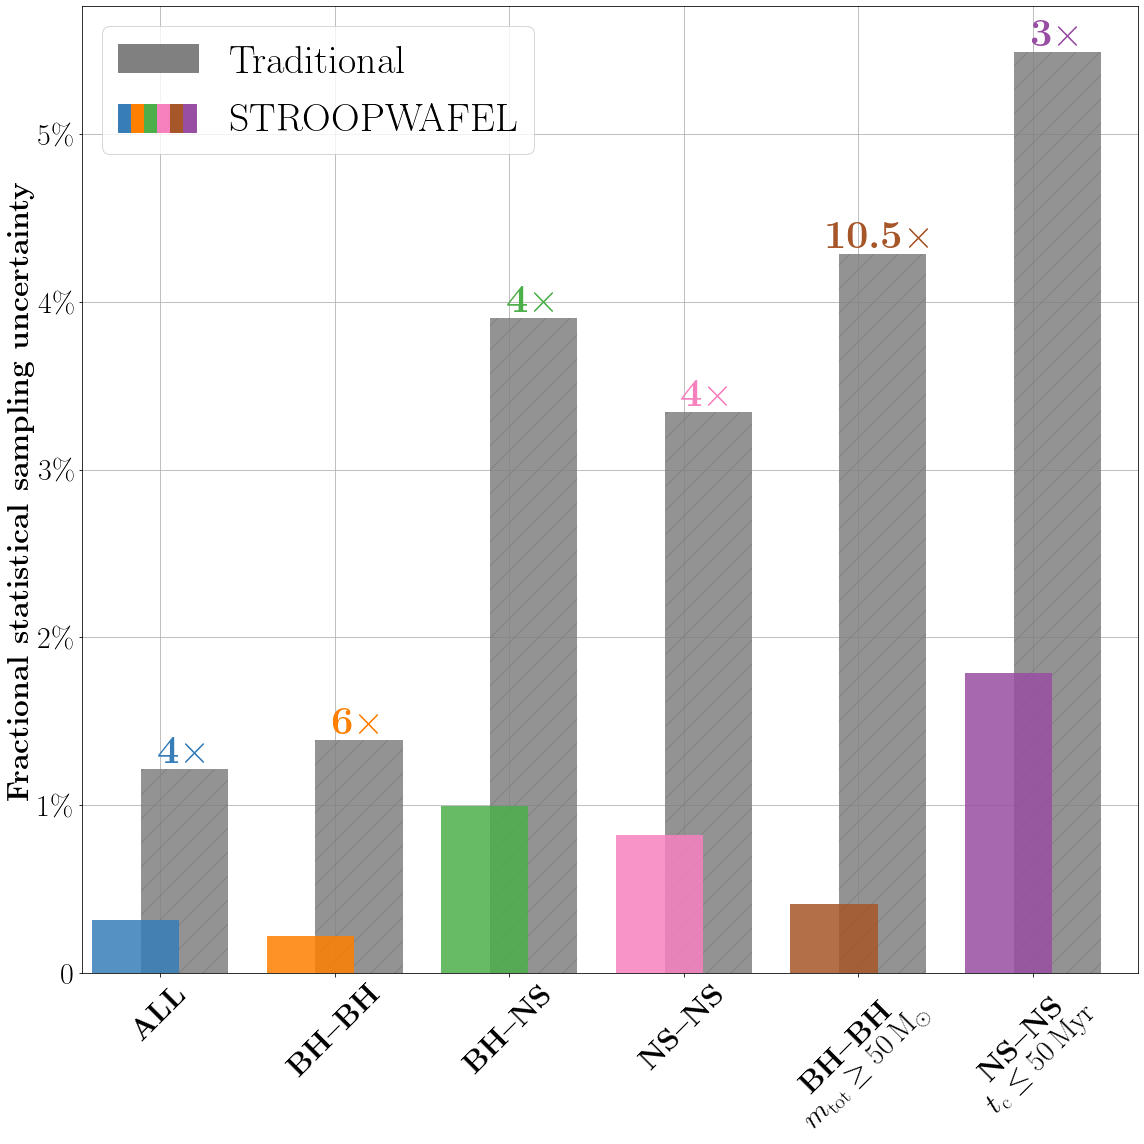

In [13]:
import matplotlib.patches as mpatches  # needed to plot the legend

# colors used for bars
colors =  ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3'] 

f, axarr= plt.subplots(1, 1,  figsize=(16,16)) 


# for all target populations, calculate and plot the fractional sampling uncertainties \n
# for the Traditional and STROOPWAFEL simulation. Print the ratio. 
plotUncertainties(axarr, 'ALL', 0, pathData)
plotUncertainties(axarr, 'BHBH', 1, pathData)
plotUncertainties(axarr, 'BHNS', 2, pathData)
plotUncertainties(axarr, 'NSNS', 3, pathData)
plotUncertainties(axarr, 'BHBH_50Msun', 4, pathData)
plotUncertainties(axarr, 'NSNS_50Myr', 5, pathData)



### the code below makes the plot look better
red_patch = mpatches.Patch(color='gray',  label=r'Traditional')
default_patch = mpatches.Patch(color='w', label='STROOPWAFEL')
plt.legend(handles=[red_patch, default_patch], fontsize = 40, loc = 'upper left')


for i in range(6):
    r2 = mpatches.Rectangle((-0.244+(i*0.075), 0.05013), 0.075, 0.00167, fill=True, color=colors[i], zorder = 10 )
    axarr.add_patch(r2)

DCOLabelList = [r'\textbf{ALL}'  , r'\textbf{BH--BH}'  , r'\textbf{BH--NS}' , \
                r'\textbf{NS--NS}' , r'$\rm{\textbf{BH--BH}}$' + '\n' + r'${m_{\rm{tot}}\geq 50 \, \rm{M}_{\odot}} $'  , \
                r'$\rm{\textbf{NS--NS}}$' + '\n' + r' ${t_{\rm{c}} \leq 50 \, \rm{Myr}} $'  ]

axarr.set_ylabel(r'\textbf{Fractional statistical sampling uncertainty}', fontsize = 30)
plt.xticks([0, 1, 2, 3, 4, 5], DCOLabelList, rotation= 45, fontsize = 30)
plt.yticks([0, .01, .02,.03, 0.04, 0.05], [r'$0$', r'$1\%$',r'$2\%$', r'$3\%$', r'$4\%$', r'$5\%$',], fontsize = 30)
plt.xlim(-0.45, 5.6)
plt.grid(True)
plt.tight_layout()

plt.show() 



##  4. Plot chirp mass distribution


Using the data from the BHNS simulation (simulation 3), the function `plotChirpmass()` below recreates the most important features of Figure 8 in  https://arxiv.org/pdf/1905.00910.pdf. <br>

We have left out a few details of the plot, such as the error bars in the right hand side of the figure and the uncertainty/bin lines, to decrease the complexity of this example. 

In [14]:

def chirpmass(m1=10, m2=20):
    '''calculates chirp mass for 2-body system with component masses m1 and m2'''
    numer = (m1*m2)**(3./5)
    denom = (m1+m2)**(1./5)
    return numer/denom



def plotChirpmass(simulation='BHNS', DCOtype='BHNS', path=pathData):
    """function that creates figure 8 from https://arxiv.org/pdf/1905.00910.pdf
    //
    parameters:
    simulation # name of simulation. Options are: Traditional, 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun'
    DCOtype # describes target binary. Options are: 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun
    path # pathname to Directory where _exploratory & _refinement directories are
    """

    f, axarr= plt.subplots(1, 2,  figsize=(22,8)) 
    
   
    # obtain Traditional data
    M1_0, _ = obtaindataSTROOPWAFEL(paramHeader='M1', simulation='Traditional',\
                          datafile='allDoubleCompactObjects.dat', path=path)
    M2_0, weights_0 = obtaindataSTROOPWAFEL(paramHeader='M2', simulation='Traditional',\
                          datafile='allDoubleCompactObjects.dat', path=path)    
    DCOmask_0 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation='Traditional', boolDCOmask=[1,1,0], path=path) 
    M1_0, M2_0, weights_0 = M1_0[DCOmask_0], M2_0[DCOmask_0], weights_0[DCOmask_0]
    Mchirp_0 = chirpmass(M1_0, M2_0)
    
    # obtain STROOPWAFEL data
    M1_1, _ = obtaindataSTROOPWAFEL(paramHeader='M1', simulation=simulation,\
                          datafile='allDoubleCompactObjects.dat', path=path)
    M2_1, weights_1 = obtaindataSTROOPWAFEL(paramHeader='M2', simulation=simulation,\
                          datafile='allDoubleCompactObjects.dat', path=path)    
    DCOmask_1 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation=simulation, boolDCOmask=[1,1,0], path=path) 
    M1_1, M2_1, weights_1 = M1_1[DCOmask_1], M2_1[DCOmask_1], weights_1[DCOmask_1]    
    Mchirp_1 = chirpmass(M1_1, M2_1)    
    

    
    # Rate     # obtain a parameter from the allSystems.dat to get the total Number of binaries simulated of Traditional simulation
    ID, _ = obtaindataSTROOPWAFEL(paramHeader='ID', simulation=simulation,\
                                  datafile='allSystems.dat', path=path)
    NbinariesSampled = len(ID)
    
    # left panel 
    nbins=30
    bins = np.linspace(min(Mchirp_1), max(Mchirp_1), nbins)
    axarr[0].hist(Mchirp_1, bins=bins, color='#4daf4a', edgecolor='#4daf4a')
    axarr[0].hist(Mchirp_0, bins=bins, color='gray', edgecolor='gray') 

    # right panel
    axarr[1].hist(Mchirp_1, bins=bins, color='#4daf4a', edgecolor='#4daf4a', weights=weights_1 , density=True)# 
    axarr[1].hist(Mchirp_0, bins=bins, color='gray', edgecolor='gray', density=True, histtype='step', lw=6, weights=weights_0)

    
    ##### the remaining blocks of lines just make the plot look nicer #####
    # add some text in the plot
    axarr[0].annotate(r"STROOPWAFEL (%s)"%len(Mchirp_1), xy=(0.56, 0.85), \
                      xycoords='axes fraction', fontsize=22, color='#4daf4a', weight='bold')
    axarr[0].annotate(r"Traditional (%s)"%len(Mchirp_0), xy=(0.56, 0.80), \
                      xycoords='axes fraction', fontsize=22, color='grey', weight='bold') 
    axarr[0].annotate(r"BH-NS  mergers", xy=(0.036, 0.92), xycoords='axes fraction', fontsize=30, weight='bold') 
    axarr[1].annotate(r"STROOPWAFEL (%s)"%len(Mchirp_1), xy=(0.56, 0.85), \
                      xycoords='axes fraction', fontsize=22, color='#4daf4a', weight='bold')
    axarr[1].annotate(r"Traditional (%s)"%len(Mchirp_0), xy=(0.56, 0.80), \
                      xycoords='axes fraction', fontsize=22, color='grey', weight='bold') 
    axarr[1].annotate(r"BH-NS  mergers", xy=(0.036, 0.92), xycoords='axes fraction', fontsize=30, weight='bold') 
    
    
    # set axes limits
    axarr[0].set_xlim(min(Mchirp_1), max(Mchirp_1))    
    axarr[0].set_ylim(1, 2*1E4)
    axarr[0].set_yscale('log')
    axarr[1].set_xlim(min(Mchirp_1), max(Mchirp_1))  
    axarr[1].set_ylim(0, 0.55) 
    
    # ticks and grid
    axarr[0].grid()
    axarr[0].tick_params(labelsize=24)
    axarr[1].grid()
    axarr[1].tick_params(labelsize=24)  
    
    # x- and y-labels
    xlabel =  r'$ \, m_{\rm{chirp}} \, [\rm{M}_{\odot}]$' 
    axarr[0].set_xlabel(xlabel, fontsize=30)
    axarr[0].set_ylabel(r' Number of hits $ N_{\rm{T}}$', fontsize=30)
    axarr[1].set_xlabel(xlabel, fontsize=30)
    axarr[1].set_ylabel(r'$ p(m_{\rm{chirp}}) \, / \,\rm{M}_{\odot}$ ', fontsize=30)
    ########
    
    plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
    plt.show() 

    return 



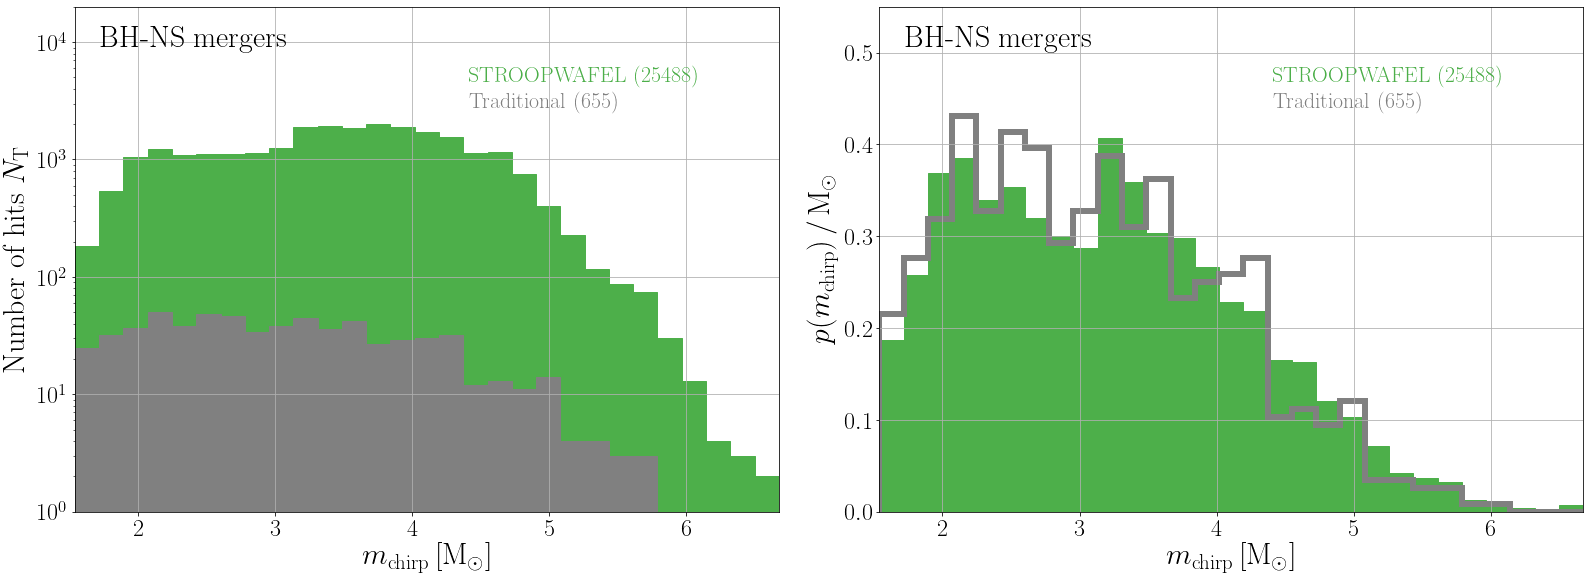

In [15]:
# create most important features of figure 8 in STROOPWAFEL paper: 
plotChirpmass(simulation='BHNS', DCOtype='BHNS', path=pathData)



##  5. Plot chirp mass kde distribution

Using the data from the BHNS simulation (simulation 3), the function `plotChirpmass_kde()` below recreates the most important features of Figure 9 in  https://arxiv.org/pdf/1905.00910.pdf. <br>


This function uses the scipy gaussian_kde class which is defined below. 

In the paper I used repeats=1000

In [16]:
import numpy as np
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method): # and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

        
        

def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest





In [17]:
def obtain_ordered_masses(m1, m2):
    """returns m1 and m2 but now ordered in masses 
    m1 is always the heaviest object"""
    m1_heavy, m2_light = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = ( m1 >= m2)
    maskm2heavier = (m1 < m2)
    
    m1_heavy[maskm1heavier] = m1[maskm1heavier] 
    m1_heavy[maskm2heavier] = m2[maskm2heavier]
    m2_light[maskm1heavier] = m2[maskm1heavier]
    m2_light[maskm2heavier] = m1[maskm2heavier]
    
    return m1_heavy, m2_light # m1_heavy has all the heaviest systems



def obtainLIGOsensitivityWeights(m1,m2, weights):
    """function that transforms the sample weights to include the rough observational bias of LIGO/Virgo  """
    m1_heavy, m2_light = obtain_ordered_masses(m1, m2)
    LIGOsensitivity = (m1_heavy)**(2.2) / (np.sum((m1_heavy)**(2.2))) # normalize and Power 2.2 from Fishbach & Holz 2017 
    norm_weights = weights / np.sum(weights)
    LIGO_weights = norm_weights * LIGOsensitivity

    return LIGO_weights


def bootstrapkde(repeats, samples, weights, bins, bandwidths):
    """bootstraps the kde function to obtain 1- and 2-sigma 
    uncertainty intervals for the kde plotted in plotChirpmass_kde() """
    
    # make array where we will save each bootstrap result
    nbins = len(bins)
    array_probailities = np.zeros((repeats, nbins))
    
    xx_boot = bins
    weights /= np.sum(weights) # normalize weights        

    samples = np.asarray(samples)       
    boot_index = np.arange(len(samples))                                  
    for nr in range(repeats):
        # (bootstrap) re-sample a random set of samples with replacement from existing samples
        # do this by drawing random sample indecis nrs, each nr corresponds to a sample  
        boot_randindex = np.random.choice(boot_index, size=len(boot_index), replace=True, p=None)
        boot_randweight   = np.asarray(weights)[boot_randindex] # get the corresponding weights 
        boot_randsamples   = np.array(np.asarray(samples)[boot_randindex]) # get the corresponding samples
        
        # calculate the kde for this bootstrap 
        pdf_boot = gaussian_kde(boot_randsamples, weights=boot_randweight, bw_method = bandwidths)
        y_boot = pdf_boot(xx_boot)
        # add bootstrap kde to array
        array_probailities[nr,:] =  y_boot
    
    # calculate the 1- and 2-sigma uncertainties from these bootstraps for below and above mean. 
    percentile_min1sigma = np.percentile(array_probailities, 15.89, axis=0)
    percentile_plus1sigma = np.percentile(array_probailities, 84.1, axis=0)
    percentile_min2sigma = np.percentile(array_probailities, 2.27, axis=0)
    percentile_plus2sigma = np.percentile(array_probailities, 97.725, axis=0)    
        
    std_bins = (np.std(array_probailities, axis=0)) 

    return [percentile_min1sigma, percentile_plus1sigma, percentile_min2sigma, percentile_plus2sigma]


def plotChirpmass_kde(repeats, simulation='BHNS', DCOtype='BHNS', path=pathData):
    """function that creates figure 8 from https://arxiv.org/pdf/1905.00910.pdf
    //
    parameters:
    simulation # name of simulation. Options are: Traditional, 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun'
    DCOtype # describes target binary. Options are: 'ALL', 'BHNS', 'BBH', 'NSNS', 'NSNS_50Myr' and 'BHBH_50Msun
    path # pathname to Directory where _exploratory & _refinement directories are
    repeats # nr of bootstraps 
    """

    f, axarr= plt.subplots(1, 1,  figsize=(16,10)) 
    
   
    # obtain Traditional data
    M1_0, _ = obtaindataSTROOPWAFEL(paramHeader='M1', simulation='Traditional',\
                          datafile='allDoubleCompactObjects.dat', path=path)
    M2_0, weights_0 = obtaindataSTROOPWAFEL(paramHeader='M2', simulation='Traditional',\
                          datafile='allDoubleCompactObjects.dat', path=path)    
    DCOmask_0 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation='Traditional', boolDCOmask=[1,1,0], path=path) 
    M1_0, M2_0, weights_0 = M1_0[DCOmask_0], M2_0[DCOmask_0], weights_0[DCOmask_0]
    Mchirp_0 = chirpmass(M1_0, M2_0)
    
    # obtain STROOPWAFEL data
    M1_1, _ = obtaindataSTROOPWAFEL(paramHeader='M1', simulation=simulation,\
                          datafile='allDoubleCompactObjects.dat', path=path)
    M2_1, weights_1 = obtaindataSTROOPWAFEL(paramHeader='M2', simulation=simulation,\
                          datafile='allDoubleCompactObjects.dat', path=path)    
    DCOmask_1 = maskTargetDCOsSTROOPWAFEL(DCOtype=DCOtype, simulation=simulation, boolDCOmask=[1,1,0], path=path) 
    M1_1, M2_1, weights_1 = M1_1[DCOmask_1], M2_1[DCOmask_1], weights_1[DCOmask_1]    
    Mchirp_1 = chirpmass(M1_1, M2_1)    
    
    
    # Rate     # obtain a parameter from the allSystems.dat to get the total Number of binaries simulated of Traditional simulation
    ID, _ = obtaindataSTROOPWAFEL(paramHeader='ID', simulation=simulation,\
                                  datafile='allSystems.dat', path=path)
    NbinariesSampled = len(ID)
    

    # calculate the weights when including observational bias
    weights_0 = obtainLIGOsensitivityWeights(M1_0, M2_0, weights_0)    
    weights_1 = obtainLIGOsensitivityWeights(M1_1, M2_1, weights_1)        
    weights_0 /= np.sum(weights_0) # normalize weights  
    weights_1 /= np.sum(weights_1) # normalize weights  

    # settings for kde 
    nbins = 500
    poissonErr = 4
    bandwidths = 0.095
    bins = np.linspace(min(Mchirp_1), max(Mchirp_1), nbins)
    

    ####### 
    # plot main (i.e. mean) kde line for Traditional Monte Carlo:    
    kde_0 = gaussian_kde(Mchirp_0, weights=weights_0 , bw_method =bandwidths)        
    yy_0 = kde_0(bins)
    axarr.plot(bins, yy_0, lw=3, color='grey', zorder=2003)
    
    # plot main (i.e. mean) kde line for STROOPWAFEL:
    kde_1 = gaussian_kde(Mchirp_1, weights=weights_1 , bw_method =bandwidths)        
    yy_1 = kde_1(bins)    
    axarr.plot(bins, yy_1, lw=3, color ='#4daf4a', zorder=2006)
    
    
    #########
    ## calculate the 1- and 2-sigma uncertainties using bootstrapping and plot those:
    
    # Traditional Monte Carlo:
    percentiles_0 = bootstrapkde(repeats=repeats, samples=Mchirp_0, \
                                 weights=weights_0, bins=bins, bandwidths=bandwidths)
    axarr.fill_between(bins, percentiles_0[1], percentiles_0[0], \
                       alpha = 0.75, color = 'grey', zorder = 2001)
    axarr.fill_between(bins, percentiles_0[3], percentiles_0[2], \
                       alpha = 0.45, color = 'grey', zorder = 2000)

    # STROOPWAFEL:
    percentiles_1 = bootstrapkde(repeats=repeats, samples=Mchirp_1, \
                                 weights=weights_1, bins=bins, bandwidths=bandwidths)
    axarr.fill_between(bins, percentiles_1[1], percentiles_1[0], \
                       alpha = 0.75, color ='#4daf4a', zorder = 2005)
    axarr.fill_between(bins, percentiles_1[3], percentiles_1[2], \
                       alpha = 0.45, color ='#4daf4a', zorder = 2004)
    
    
    ##### the remaining blocks of lines just make the plot look nicer #####
    # add some text in the plot
    axarr.annotate(r"STROOPWAFEL (%s)"%len(Mchirp_1), xy=(0.036, 0.85), \
                      xycoords='axes fraction', fontsize=22, color='#4daf4a', weight='bold')
    axarr.annotate(r"Traditional (%s)"%len(Mchirp_0), xy=(0.036, 0.80), \
                      xycoords='axes fraction', fontsize=22, color='grey', weight='bold') 
    axarr.annotate(r"BH-NS  mergers", xy=(0.036, 0.92), xycoords='axes fraction', fontsize=30, weight='bold') 

    # set axes limits
    axarr.set_xlim(min(Mchirp_1), max(Mchirp_1))    
    axarr.set_ylim(0, 0.85)


    # ticks and grid
    axarr.grid()
    axarr.tick_params(labelsize=24)

    
    # x- and y-labels
    xlabel =  r'$ \, m_{\rm{chirp}} \, [\rm{M}_{\odot}]$' 
    ylabel = r'$ \, p(m_{\rm{chirp}}) / \, \rm{M}_{\odot}$'
    axarr.set_xlabel(xlabel, fontsize=30)
    axarr.set_ylabel(ylabel, fontsize=30)

    ########
    
    plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
    plt.show() 

    return 




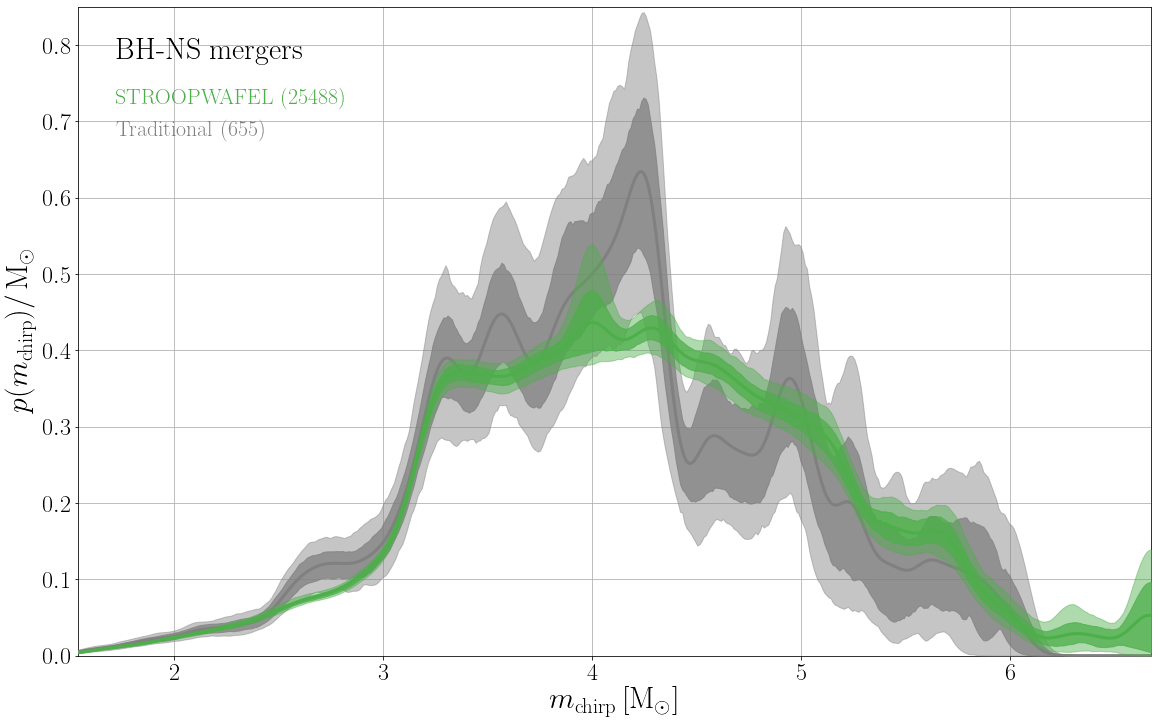

In [18]:

# create most important features of figure 9 in STROOPWAFEL paper: 
plotChirpmass_kde(repeats=200, simulation='BHNS', DCOtype='BHNS', path=pathData)










